In [1]:
import os
from tqdm.notebook import trange, tqdm
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from dipy.viz import regtools
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show
from sklearn.decomposition import FastICA, PCA

from nilearn import datasets
from nilearn.input_data import NiftiMasker
from scipy.stats import zscore
from scipy.io import loadmat
from tensorly.decomposition import parafac
from IPython.display import Image

save_results = 'results/'
if not os.path.exists(save_results):
    os.makedirs(save_results)

sns.set_theme(style="white", palette=None)
%matplotlib inline

C:\Users\maxim\anaconda3\envs\NX-421\lib\site-packages\dipy\viz\__init__.py:20: UserWarning: You do not have FURY installed. Therefore, 3D visualization functions will not work for you. Please install or upgrade FURY using pip install -U furyFor detailed installation instructions visit: https://fury.gl/
  warnings.warn(
C:\Users\maxim\anaconda3\envs\NX-421\lib\site-packages\nilearn\input_data\__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
!pip install tqdm
!pip install fury
!pip install nibabel
!pip install nistats
!pip install nilearn
!pip install tensorly
!pip install nltools

  Using cached fury-0.8.0-py3-none-any.whl (349 kB)
  Using cached vtk-9.2.2-cp38-cp38-win_amd64.whl (49.3 MB)
  Attempting uninstall: vtk
    Found existing installation: vtk -PKG-VERSION


ERROR: Cannot uninstall 'vtk'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


# load the data  (TODO : importer les autres datas de open neuro)

In [3]:
img = nib.load('sub-control01_func_sub-control01_task-music_run-1_bold.nii')
data = img.get_data()
data.shape

C:\Users\maxim\AppData\Local\Temp\ipykernel_9592\2334609891.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data = img.get_data()


(80, 80, 50, 105)

In [27]:
df = pd.read_csv('sub-03_func_sub-03_task-dis_run-01_events.tsv', sep ='\t')
df

,onset,duration,trial_type
0,0.0,33.0,tones
1,33.0,3.0,response
2,36.0,31.5,negative_music
3,67.5,3.0,response
4,70.5,31.5,tones
5,102.0,3.0,response
6,105.0,31.5,positive_music
7,136.5,3.0,response
8,139.5,31.5,tones
9,171.0,3.0,response


***Description of the dataset:***   

The data set is called : "Neural Processing of Emotional Musical and Nonmusical Stimuli in Depression".
Patients are listening to different types of music, validated emotional music and nonmusical auditory paradigm. The dataset presents fMRI of these experiments on 19 patients with depression and 20 without, to examine how neural processing of emotionally provocative auditory stimuli is altered in depression.
   
In this first dataset, the patient is listening at a serie of 10 events each labeled in the column 'trial_type'.   

The data has a 4D shape since it represents the acquisition signal per voxel at a given time.   

***We will try to answer the following question :***

What brain region is involoved when listening to postive and neagtive type of music? Is there any different pattern between patient with depression and those without?


## Methodology 

Our first goal will be to project the original voxel-dimensional data matrix (time-by-voxels) into a lower-dimensional "component" matrix space (time-by-component) without losing significant information.   

To do so, we will first, run a PCA on our 166 voxels. This will indicate us basises with maximum information. 
Mathematicaly, we take the covariance matrix $X^T\dot{X}$ and apply an SVD on it i.e. we resolve the following equality :    
$C = X^T\dot{X} = US^2U^T$ (this can be done simply by using the numpy function : np.linalg.svd).   
Singular vectors $u_k$ from the Matrix U, will give us eigenvectors of C.   
By sorting the eigenvectors by decreasing order, we obtain dircetions where variances are maximal i.e. basis with maximum of information.



# Preprocessing with only 2 voxels #

In [11]:
vol_shape = data.shape[:-1]
n_vols = data.shape[-1]

In [12]:
print(vol_shape)
print(n_vols)

(80, 80, 50)
105


In [13]:
first_two = data[..., :2]
first_two.shape

(80, 80, 50, 2)

In [14]:
# Set N to be the number of voxels in a volume
N = np.prod(vol_shape)
# Reshape to 2D array with first dimension length N
first_two = first_two.reshape((N, 2))
first_two.shape
# Transpose to 2 by N array
first_two = first_two.T
first_two.shape

(2, 320000)

In [15]:
# Calculate the mean across columns
row_means = np.mean(first_two, axis=1)
# Row means copied N times to become a 2 by N array
row_means = np.outer(row_means, np.ones(N))
# Subtract the means for each row, put the result into X
X = first_two - row_means
# Show the means over the columns, after the subtraction
np.mean(X, axis=1)

array([ 8.94488039e-14, -3.73347575e-14])

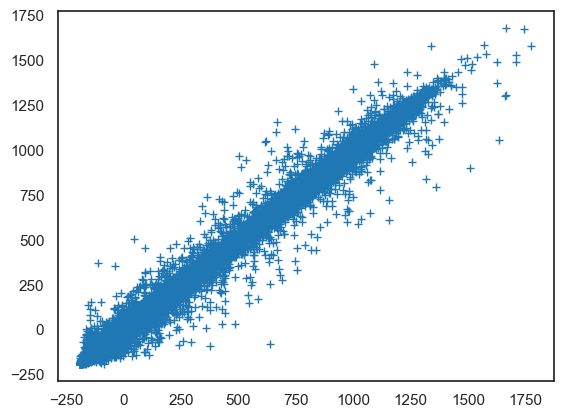

In [16]:
# Plot the signal in the first row against the signal in the second
plt.plot(X[0], X[1], '+')

Voxel1 and voxel2 are very correlated since X[0] vs X[1] form a line close to X[0]=X[1] which is not too sparse. Maybe it is due to the time proximity, let see with 2 random times...

21 86


Text(0, 0.5, 'Voxel 86')

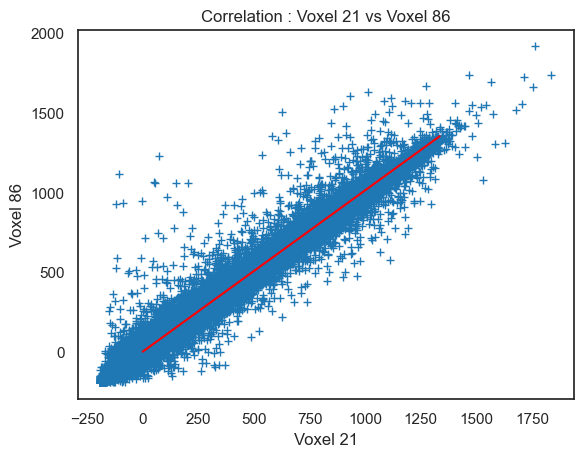

In [52]:
r1, r2 = np.random.randint(low=0, high=n_vols, size=2, dtype=int)
print(r1, r2)

d1 = data[..., r1]
d2 = data[..., r2]

# Reshape to 2D array with first dimension length N
d1 = d1.reshape((N, 1))
d2 = d2.reshape((N, 1))
two_random = np.hstack((d1, d2))
# Transpose to 2 by N array
two_random = two_random.T
two_random.shape

# Calculate the mean across columns
row_means_2 = np.mean(two_random, axis=1)
# Row means copied N times to become a 2 by N array
row_means_2 = np.outer(row_means_2, np.ones(N))
# Subtract the means for each row, put the result into X
X_2 = two_random - row_means_2
# Show the means over the columns, after the subtraction
np.mean(X_2, axis=1)


# Compute the covariance matrix 
covariance_matrix = X_2@X_2.T

# Apply SVD to get U, S, VT matrices from covariance matrix
U_2, S_2, VT_2 = np.linalg.svd(covariance_matrix)

# Plot the signal in the first row against the signal in the second
# Plot line corresponding to a scaled version of the first principal component
plt.plot(X_2[0], X_2[1], '+') #we don't plot anymore the 2 first but 166 first, so we don't...
scaled_u = U_2[0, :] *-1900
plt.plot([0, scaled_u[0]], [0, scaled_u[1]], 'r-')
plt.title("Correlation : Voxel %d vs Voxel %d" %(r1, r2))
plt.xlabel("Voxel %d" %(r1))
plt.ylabel("Voxel %d" %(r2))

### Plot real data ###

Text(0.5, 1.0, 't2 = 86')

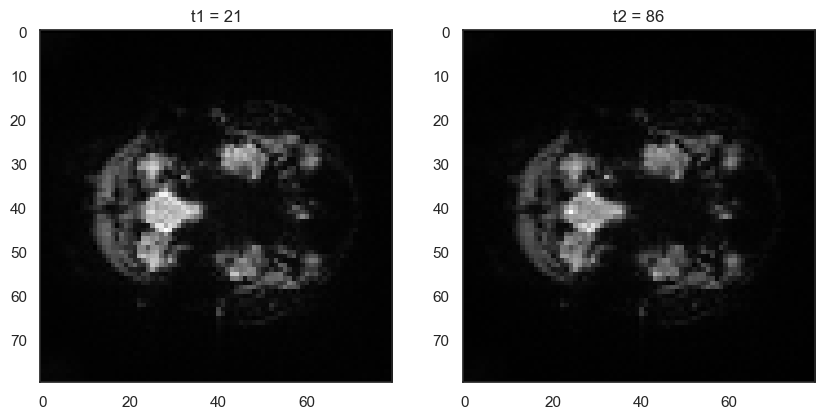

In [71]:
a0 = data[..., r1]
a1 = data[..., r2]
z = 6  #z-axis of the slice

# setting values to rows and column variables
rows = 1
columns = 2

# create figure
fig = plt.figure(figsize=(10, 7))

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(a0[:, :, z], cmap='gray')
plt.title("t1 = %d" %r1)
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(a1[:, :, z], cmap='gray')
plt.title("t2 = %d" %r2)


### Plot PCA projected data ###

In [65]:
# Calculate the scalar projections for projecting X onto the vectors in U.
# Put the result into a new array C.
C_2 = U_2.T@two_random

# Transpose C
# Reshape the first dimension of C to have the 3D shape of the original data volumes.
C_vols = C_2.T.reshape(vol_shape + (two_random.shape[0],))
print(C_vols.shape)

(80, 80, 50, 2)


Text(0.5, 1.0, 'Projection on the second component')

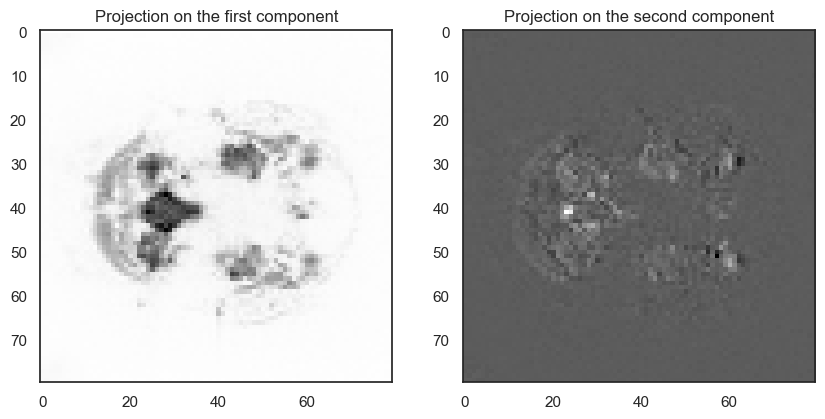

In [72]:
#- Break 4D array into 3D volumes
vol0 = C_vols[..., 0]
vol1 = C_vols[..., 1]

# setting values to rows and column variables
rows = 1
columns = 2

# create figure
fig = plt.figure(figsize=(10, 7))

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(vol0[:, :, z], cmap='gray')
plt.title("Projection on the first component")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(vol1[:, :, z], cmap='gray')
plt.title("Projection on the second component")

# Take all the data, not only the 2 first one #

In [73]:
#take the whole data and reshape it
d = np.zeros((N, 1))
for i in range(data.shape[-1]):
    d = np.hstack((d, data[..., i].reshape((N, 1))))

#remove the first column of ones
d = np.delete(d, 0, axis=1)
d = d.T
print("shape of d : ", d.shape)

shape of d :  (105, 320000)


In [102]:
# Calculate the mean across columns
row_means_d = np.mean(d, axis=1)
# Row means copied N times to become a 166 by N array
row_means_d = np.outer(row_means_d, np.ones(N))
# Subtract the means for each row, put the result into X
X_d = d - row_means_d

### Apply PCA ###

In [75]:
X_d.shape
print(X_d[2].shape)

(320000,)


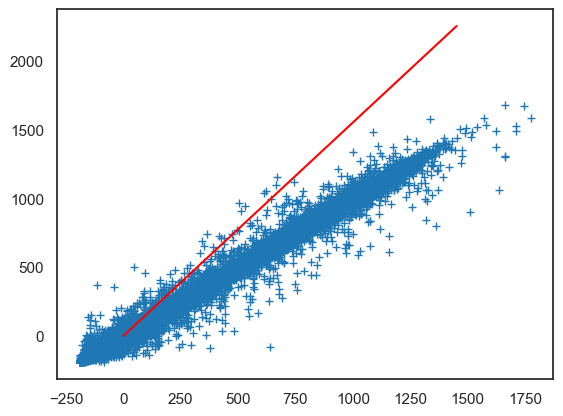

In [84]:
# Compute the covariance matrix 
covariance_matrix_d = X_d@X_d.T

# Apply SVD to get U, S, VT matrices from covariance matrix
U_d, S, VT = np.linalg.svd(covariance_matrix_d)

# Plot the signal in the first row against the signal in the second
# Plot line corresponding to a scaled version of the first principal component
plt.plot(X_d[0], X_d[1], '+') #we don't plot anymore the 2 first but 166 first, so we don't...
scaled_u = U_d[0, :] *-15000
plt.plot([0, scaled_u[0]], [0, scaled_u[1]], 'r-')

In [89]:
# Calculate the scalar projections for projecting X onto the vectors in U.
# Put the result into a new array C.
C_d = U_d.T@d

# Transpose C
# Reshape the first dimension of C to have the 3D shape of the original data volumes.
C_vols_d = C_d.T.reshape(vol_shape + (d.shape[0],))
print(C_vols_d.shape)


(80, 80, 50, 105)


Text(0.5, 1.0, 'Projection on the 4th component')

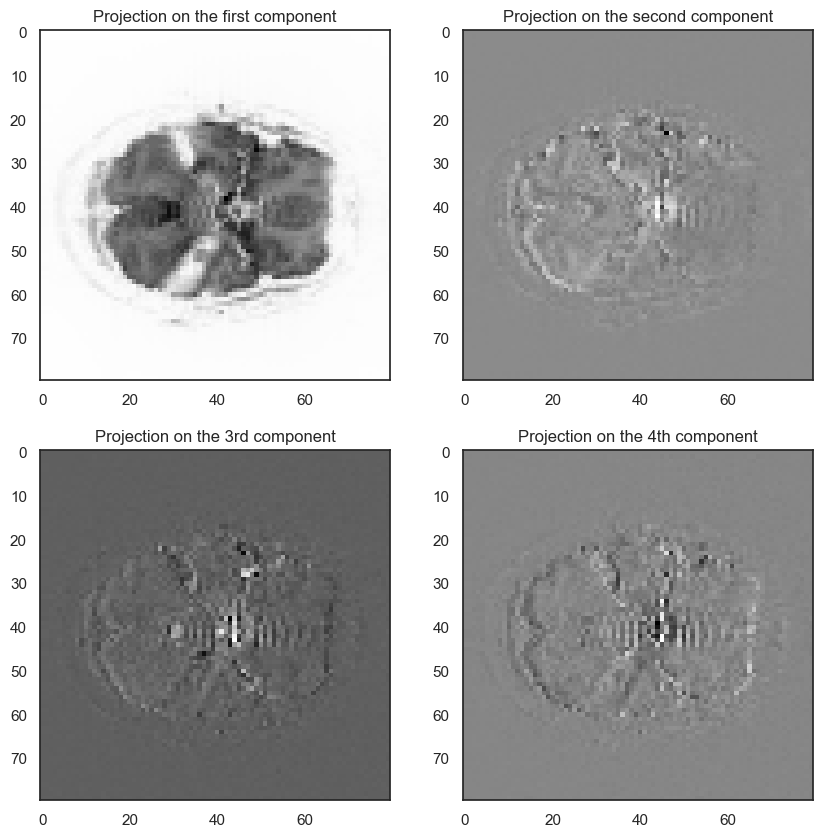

In [92]:
#- Break 4D array into 3D volumes
vol0 = C_vols_d[..., 0]
vol1 = C_vols_d[..., 1]
vol2 = C_vols_d[..., 2]
vol3 = C_vols_d[..., 3]

# setting values to rows and column variables
rows = 2
columns = 2

# create figure
fig = plt.figure(figsize=(10, 10))

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(vol0[:, :, z], cmap='gray')
plt.title("Projection on the first component")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(vol1[:, :, z], cmap='gray')
plt.title("Projection on the second component")

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(vol2[:, :, z], cmap='gray')
plt.title("Projection on the 3rd component")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 4)

# showing image
plt.imshow(vol3[:, :, z], cmap='gray')
plt.title("Projection on the 4th component")

## Using nltools 

In [104]:
from nltools.data import Brain_Data
from nltools.plotting import component_viewer

data_nl = Brain_Data(img)

C:\Users\maxim\anaconda3\envs\NX-421\lib\site-packages\nilearn\image\resampling.py:545: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


In [107]:
data_nl = data_nl.filter(sampling_freq=1/2.4, high_pass=1/128)

data_nl = data_nl.smooth(6)

In [111]:
tr = 2.3
output = data_nl.decompose(algorithm='pca', n_components=105, axis='images', whiten=True)

In [112]:
component_viewer(output, tr=tr)

interactive(children=(BoundedIntText(value=0, description='Component', max=104), BoundedFloatText(value=2.0, d…

## Remark

We lose more and more information on the plot as the eigenvectors become small. From a certain value i, C[ : , : , i ] meaures only noise.

## Process with ICA

In [ ]:
from nltools.data import Brain_Data

In [ ]:

img = nib.load('sub-03_func_sub-03_task-dis_run-01_bold.nii')
data = img.get_data()
data.shape